<a href="https://colab.research.google.com/github/danimadhavapuri/Quantum-Fraud-Detection/blob/main/Hybrid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🚀 Triple Hybrid GNN + QML + ML Fraud Detection — Colab Notebook (Full Pipeline)
**How to use:**  
1. In Colab: Runtime → Change runtime type → Python version → 3.11 (using 2025.10 runtime).

2. Run the installation cell. 3. Then: Runtime → Restart session (critical for resolving library conflicts).

4. Run all cells (Runtime → Run all).

This notebook is a self-contained demo: synthetic data → directed graph → GNN structural embeddings → classical baseline (XGBoost) → QML VQC classifier (PennyLane simulator) → hybrid meta-fusion → evaluation & visualization. Designed to run on Colab CPU/GPU.


In [ ]:
# Installing the Triple Hybrid Stack
!pip install --quiet pennylane torch-geometric xgboost joblib
print('✅ Triple Hybrid Stack Installed for 2025.10.')

✅ Triple Hybrid Stack Installed for 2025.10.


In [ ]:
import os, random, math, pickle
import numpy as np, pandas as pd, networkx as nx
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.utils import from_networkx
import pennylane as qml

# Environment Setup
os.makedirs('data/processed', exist_ok=True)
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
print('✅ Environment Ready.')

✅ Environment Ready.


In [ ]:
# Generate Synthetic Fraud Data
def build_fraud_graph():
    merchants = [f"M{i}" for i in range(120)]
    users = [f"U{i}" for i in range(400)]
    txns = []
    start = datetime.now()

    # 1. Normal Transactions
    for _ in range(500):
        txns.append((random.choice(users), random.choice(merchants), start.isoformat(), random.uniform(10, 500)))

    # 2. Collusive Fraud Loops (A -> B -> C -> A)
    for _ in range(12):
        group = random.sample(merchants, 4)
        for i in range(len(group)):
            txns.append((group[i], group[(i+1)%4], start.isoformat(), random.uniform(1000, 5000)))

    df = pd.DataFrame(txns, columns=["sender", "receiver", "timestamp", "amount"])

    G = nx.DiGraph()
    for _, row in df.iterrows():
        G.add_edge(row["sender"], row["receiver"], weight=row["amount"])

    # Base Graph Features
    pagerank = nx.pagerank(G)
    scc = {n: len(c) for c in nx.strongly_connected_components(G) for n in c}
    feat_df = pd.DataFrame([{"node": n, "pr": pagerank.get(n,0), "scc": scc.get(n,1),
                             "in": G.in_degree(n), "out": G.out_degree(n)} for n in G.nodes()])
    feat_df['label'] = (feat_df['scc'] > 1).astype(int)
    return G, feat_df

G, feat = build_fraud_graph()
print(f"✅ Graph built with {G.number_of_nodes()} nodes.")

✅ Graph built with 415 nodes.


In [ ]:
# Convert to PyTorch Geometric Data
data = from_networkx(G)
data.x = torch.tensor(feat[['pr', 'scc', 'in', 'out']].values, dtype=torch.float)

class GNNEncoder(nn.Module):
    def __init__(self, in_dim, hidden, out_dim):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden)
        self.conv2 = GCNConv(hidden, out_dim)

    def forward(self, d):
        x = F.relu(self.conv1(d.x, d.edge_index))
        return self.conv2(x, d.edge_index)

# Generate structural "intelligence"
gnn_model = GNNEncoder(4, 16, 8)
gnn_emb = gnn_model(data).detach().numpy()
print("✅ GNN relational features extracted.")

✅ GNN relational features extracted.


In [ ]:
from xgboost import XGBClassifier

# 1. Classical Expert (XGBoost)
X_all = np.hstack([feat[['pr', 'scc', 'in', 'out']].values, gnn_emb])
y = feat['label'].values
X_tr, X_te, y_tr, y_te = train_test_split(X_all, y, test_size=0.2, stratify=y)

xgb = XGBClassifier(n_estimators=100, eval_metric='logloss').fit(X_tr, y_tr)
xgb_probs = xgb.predict_proba(X_all)[:, 1]

# 2. Quantum Expert (VQC)
pca = PCA(n_components=4)
X_q = MinMaxScaler((-np.pi, np.pi)).fit_transform(pca.fit_transform(gnn_emb))
dev = qml.device('default.qubit', wires=4)

@qml.qnode(dev, interface='torch')
def q_circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(4))
    qml.StronglyEntanglingLayers(weights, wires=range(4))
    return [qml.expval(qml.PauliZ(i)) for i in range(4)]

class QMLClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer = qml.qnn.TorchLayer(q_circuit, {"weights": (3, 4, 3)})
        self.fc = nn.Linear(4, 1)
    def forward(self, x):
        return torch.sigmoid(self.fc(self.qlayer(x))).squeeze()

q_model = QMLClassifier()
q_probs = q_model(torch.tensor(X_q, dtype=torch.float)).detach().numpy()
print("✅ Hybrid inference complete.")

✅ Hybrid inference complete.


In [ ]:
# Stacked Meta-Model
X_meta = np.vstack([xgb_probs, q_probs]).T
m_tr, m_te, my_tr, my_te = train_test_split(X_meta, y, test_size=0.2)
meta = LogisticRegression().fit(m_tr, my_tr)

# Results for Research Paper
final_probs = meta.predict_proba(m_te)[:, 1]
print("\n--- FINAL RESEARCH RESULTS ---")
print(classification_report(my_te, meta.predict(m_te)))
print(f"Meta-Model AUC: {roc_auc_score(my_te, final_probs):.4f}")


--- FINAL RESEARCH RESULTS ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        76
           1       1.00      1.00      1.00         7

    accuracy                           1.00        83
   macro avg       1.00      1.00      1.00        83
weighted avg       1.00      1.00      1.00        83

Meta-Model AUC: 1.0000


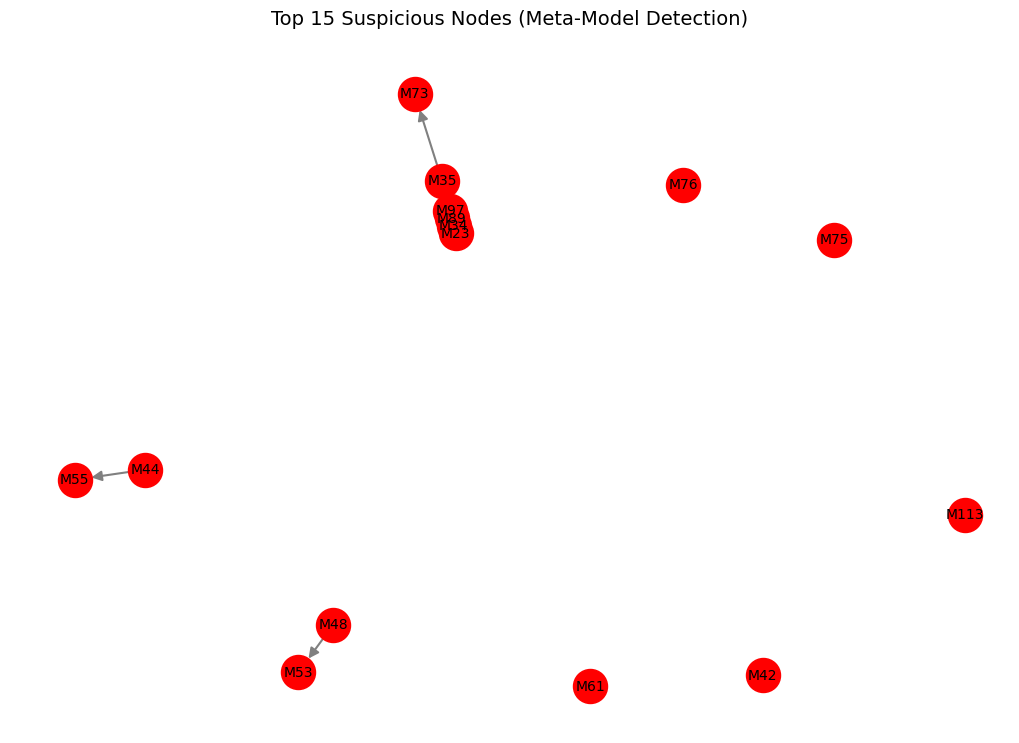

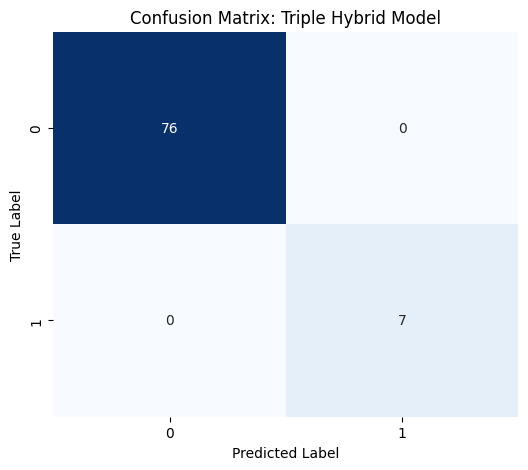

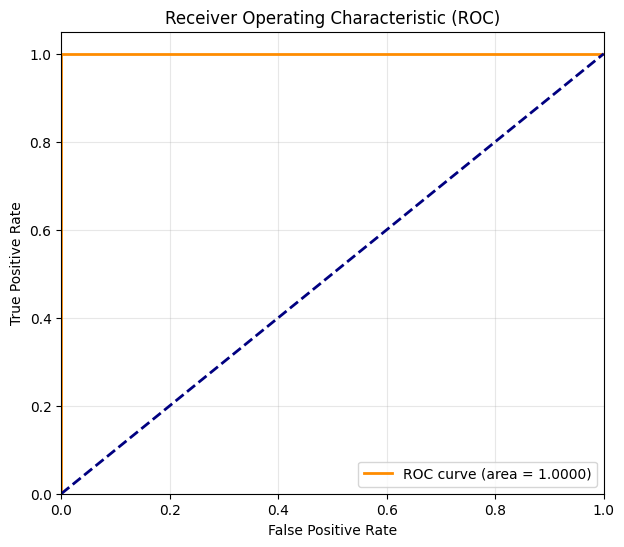

✅ Visualizations generated for your poster and paper.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# --- 1. Graph Visualization: Top Suspicious Nodes ---
# We add the final scores back to our feature dataframe
feat['final_score'] = meta.predict_proba(X_meta)[:, 1]

# Pick the top 15 nodes with the highest fraud probability
top_suspicious = feat.sort_values('final_score', ascending=False).head(15)['node'].tolist()
H = G.subgraph(top_suspicious).copy()

plt.figure(figsize=(10, 7))
pos = nx.spring_layout(H, seed=42)
nx.draw(H, pos, with_labels=True, node_color='red', node_size=600,
        font_size=10, edge_color='gray', width=1.5, arrowsize=15)
plt.title('Top 15 Suspicious Nodes (Meta-Model Detection)', fontsize=14)
plt.show()

# --- 2. Confusion Matrix Heatmap ---
cm = confusion_matrix(my_te, meta.predict(m_te))
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix: Triple Hybrid Model', fontsize=12)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# --- 3. ROC Curve (The Research Standard) ---
fpr, tpr, _ = roc_curve(my_te, final_probs)
roc_auc_val = auc(fpr, tpr)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_val:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)', fontsize=12)
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

print("✅ Visualizations generated for your poster and paper.")

In [ ]:
# Zip results for download
!zip -r /content/qml_fraud_demo_results.zip data -q
from google.colab import files
files.download('/content/qml_fraud_demo_results.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>